# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [90]:
# import libraries
import pandas as pd
import numpy as np
import sqlite3
import re
import sys
import warnings
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb

from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
#from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RepeatedKFold, train_test_split
from sklearn.multioutput import MultiOutputClassifier
#from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
#from sklearn.svm import LinearSVC
from sqlalchemy import create_engine

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("maxent_ne_chunker")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Thinkpad\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Thinkpad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\Thinkpad\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Thinkpad\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [17]:

# load data from database
engine = create_engine('sqlite:///DisasterResponse.db')
df = pd.read_sql_table("Message", engine)

X = df.message
catetories_col_names = [col for col in list(df.columns) if col not in ['index','id','message','original','genre']]
Y = df[catetories_col_names]
    

In [66]:
Y.sum().values

array([20064,  4464,   118, 10841,  2081,  1311,   724,   471,   859,
           0,  1669,  2917,  2308,   404,   603,   298,   874,  1192,
        3441,  1705,  1199,  1331,   532,   159,   283,   120,   309,
        1151,  7286,  2149,  2440,   282,  2452,   528,  1376,  5064],
      dtype=int64)

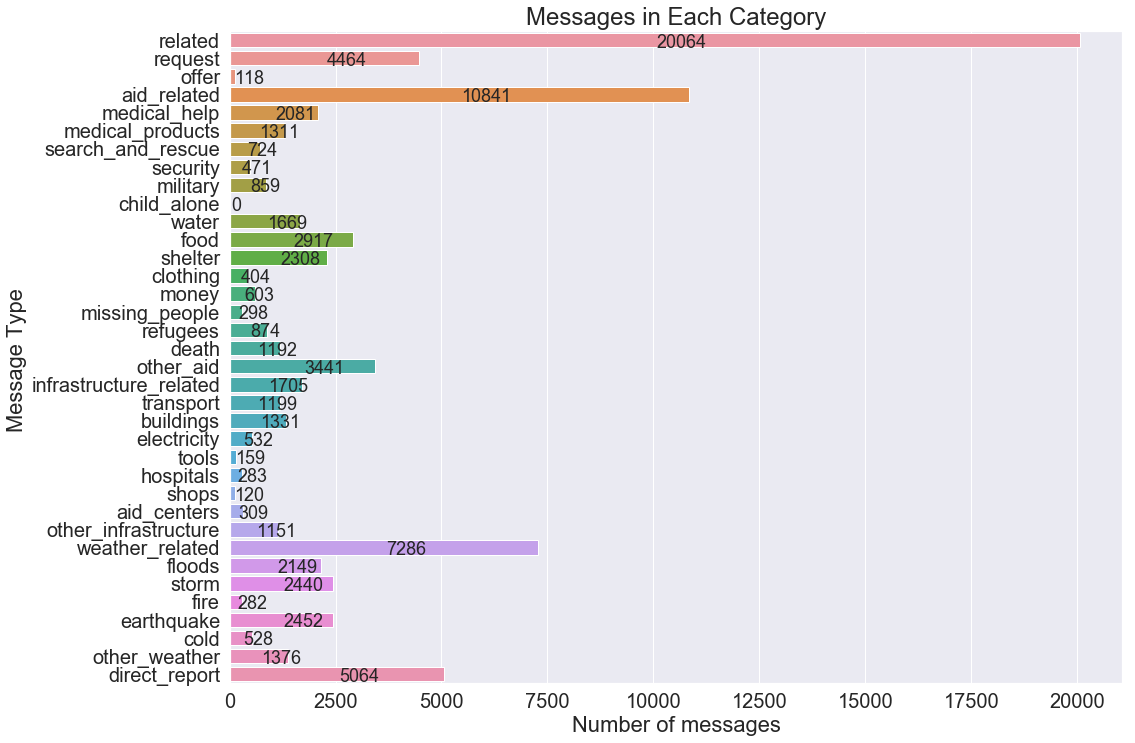

In [69]:
# barplot message frequency in each category
categories = list(Y.columns.values)
sns.set(font_scale = 2)
plt.figure(figsize=(16,12))
ax= sns.barplot(Y.sum().values,categories)
plt.title("Messages in Each Category", fontsize=24)
plt.xlabel('Number of messages', fontsize=22)
plt.ylabel('Message Type ', fontsize=22)

plt.yticks(fontsize=20)
plt.xticks(fontsize=20)


#adding the text labels
df_tmp = Y.sum().values
x_offset = 50
y_offset = 0
for p,val in zip(ax.patches,df_tmp):
    b = p.get_bbox()
    val = "{}".format(val)        
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset),fontsize=18)
    
plt.show()

In [ ]:
#barplot comments with multiple lables
rowSums = data_raw.iloc[:,2:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[1:]
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)
plt.title("Comments having multiple labels ")
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)
#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

In [63]:
# df.iloc[[108]]

In [64]:
#Y.columns

In [24]:
#for col in Y.columns:
#    print(Y[col].value_counts())

In [10]:
df.shape

(26179, 39)

In [11]:
#Y.related[Y.related==2]=1

In [12]:
#Y.related.value_counts()

### 2. Write a tokenization function to process your text data

In [70]:
#remove stop words
stop_words = set(stopwords.words('english'))
stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within'])
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)
def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)
X = X.apply(removeStopWords)

In [71]:
X.iloc[[108]]

108       factory    FIRE  road   airport near Sogeba...
Name: message, dtype: object

In [72]:
import nltk
from nltk.corpus import stopwords

import re
import sys

def cleanHtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(sentence))
    return cleantext
def cleanPunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned
def keepAlpha(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

X = X.apply(cleanHtml)
X = X.apply(cleanPunc)
X = X.apply(keepAlpha)

In [73]:
X.iloc[[108]]

108    factory FIRE road airport near Sogebank starti...
Name: message, dtype: object

In [74]:
def tokenize(text):
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [75]:
# build pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RandomForestClassifier()))
])



### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [79]:
# train classifier

X_train, X_test, y_train, y_test = train_test_split(X, Y)
pipeline.fit(X_train, y_train)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip..._score=False, random_state=None, verbose=0,
            warm_start=False),
           n_jobs=None))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [80]:
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred,target_names = y_test.keys()))


                        precision    recall  f1-score   support

               related       0.85      0.92      0.88      5010
               request       0.80      0.44      0.57      1132
                 offer       0.00      0.00      0.00        23
           aid_related       0.75      0.61      0.67      2679
          medical_help       0.56      0.10      0.17       483
      medical_products       0.72      0.09      0.16       316
     search_and_rescue       0.31      0.02      0.04       178
              security       0.00      0.00      0.00       116
              military       0.63      0.11      0.19       199
           child_alone       0.00      0.00      0.00         0
                 water       0.86      0.39      0.54       395
                  food       0.86      0.36      0.50       748
               shelter       0.79      0.31      0.45       590
              clothing       0.75      0.08      0.15       111
                 money       0.44      

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
D:\ProgramData\Anaconda3\lib\sit

### 6. Improve your model
Use grid search to find better parameters. 

In [ ]:
pipeline.get_params()

In [85]:
parameters = {
            'clf__estimator__n_estimators': [50,100,250],
            #'clf__estimator__max_depth': [2,3,5],
            #'vect__max_df': [0.5],
            #'vect__ngram_range': [(1, 1)],    
        }

cv = GridSearchCV(pipeline, param_grid=parameters)

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [86]:
cv.fit(X_train, y_train)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


KeyboardInterrupt: 

In [84]:
print(cv.best_params_)
print(cv.best_score_)

{'clf__estimator__max_depth': 2, 'clf__estimator__n_estimators': 50}
0.2022002648466945


### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

#### 8.1 Pipeline with MultinomialNB classifier

In [21]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(MultinomialNB()))
])

In [22]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred,target_names = y_test.keys()))

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                        precision    recall  f1-score   support

               related       0.77      1.00      0.87      5010
               request       0.90      0.12      0.22      1115
                 offer       0.00      0.00      0.00        32
           aid_related       0.76      0.57      0.65      2736
          medical_help       0.00      0.00      0.00       505
      medical_products       1.00      0.00      0.01       332
     search_and_rescue       0.00      0.00      0.00       189
              security       0.00      0.00      0.00       109
              military       0.00      0.00      0.00       213
           child_alone       0.00      0.00      0.00         0
                 water       0.00      0.00      0.00       409
                  food       0.33      0.00      0.01       735
               shelter       0.00      0.00      0.00       592
              clothing       0.00      0.00      0.00       105
                 money       0.00      

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### 8.2 Pipeline with LinearSVC

In [24]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(LinearSVC()))
])

In [25]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred,target_names = y_test.keys()))

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0

#### 8.3 Pipeline with XGBClassifier

In [5]:

""" 
    {'clf__estimator__eta': 0.1,
 'clf__estimator__gamma': 0.0,
 'clf__estimator__max_depth': 4,
 'clf__estimator__min_child_weight': 3}
"""

In [93]:
#xgb.XGBClassifier(eta=0.1,gamma=0.0,max_depth=4,min_child_weight=3)

In [92]:
#help(xgb.XGBClassifier)

In [28]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(xgb.XGBClassifier()))
])



In [29]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred,target_names = y_test.keys()))

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                        precision    recall  f1-score   support

               related       0.84      0.94      0.89      5010
               request       0.79      0.60      0.68      1115
                 offer       0.00      0.00      0.00        32
           aid_related       0.77      0.66      0.71      2736
          medical_help       0.58      0.28      0.37       505
      medical_products       0.65      0.30      0.41       332
     search_and_rescue       0.70      0.15      0.24       189
              security       0.60      0.03      0.05       109
              military       0.62      0.29      0.39       213
           child_alone       0.00      0.00      0.00         0
                 water       0.77      0.64      0.70       409
                  food       0.81      0.76      0.79       735
               shelter       0.78      0.59      0.68       592
              clothing       0.74      0.47      0.57       105
                 money       0.58      

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
parameters = {
     "clf__estimator__eta": [0.05, 0.10],#, 0.15, 0.20, 0.25, 0.30 #] ,
     "clf__estimator__max_depth"        : [ 3, 4],#, 5, 6, 8, 10, 12, 15],
     "clf__estimator__min_child_weight" : [ 1, 3],# 5, 7 ],
     "clf__estimator__gamma"            : [ 0.0, 0.1],#, 0.2, 0.3, 0.4 ],
     #"colsample_bytree" : [ 0.3, 0.4],# 0.5 , 0.7 ]
     }

In [47]:
cv = GridSearchCV(pipeline, param_grid=parameters)

In [41]:
pipeline.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                   lowercase=True, max_df=1.0, max_features=None, min_df=1,
                   ngram_range=(1, 1), preprocessor=None, stop_words=None,
                   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=<function tokenize at 0x000000000BCCAD90>,
                   vocabulary=None)),
  ('tfidf',
   TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)),
  ('clf',
   MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                                 colsample_bylevel=None,
                                                 colsample_bynode=None,
                                                 colsample_bytree=None, gamma=None,
                                                 gpu_id=N

In [48]:
cv.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        p

In [49]:
cv.best_params_

{'clf__estimator__eta': 0.1,
 'clf__estimator__gamma': 0.0,
 'clf__estimator__max_depth': 4,
 'clf__estimator__min_child_weight': 3}

#### 8.4 Pipeline with LogisticRegression classifier

In [50]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(LogisticRegression()))
])

In [51]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred,target_names = y_test.keys()))

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0

#### 8.5 Pipeline with AdaBoostClassifier

In [97]:
    pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(
            AdaBoostClassifier(
                base_estimator=DecisionTreeClassifier(max_depth=1, class_weight='balanced'),
                #learning_rate=0.3,
                #n_estimators=200
            )
        ))
    ])

    # Set parameters for gird search
    parameters = {
        #'clf__estimator__learning_rate': [0.1, 0.3],
        #'clf__estimator__n_estimators': [100, 200]
        'clf__estimator__learning_rate': [0.3,0.4],
        'clf__estimator__n_estimators': [200,300]
    }

    # Set grid search
    cv = GridSearchCV(estimator=pipeline, param_grid=parameters, cv=3, scoring='f1_weighted', verbose=3)


In [ ]:

# train classifier
cv.fit(X_train, y_train)

# predict on test data
y_pred = cv.predict(X_test)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=200 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
[Para

[CV]  clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=200, score=0.6285483631193441, total=10.4min
[CV] clf__estimator__learning_rate=0.3, clf__estimator__n_estimators=200 


In [95]:
print(classification_report(y_test, y_pred,target_names = y_test.keys()))

                        precision    recall  f1-score   support

               related       0.94      0.70      0.80      5010
               request       0.55      0.76      0.64      1132
                 offer       0.01      0.17      0.03        23
           aid_related       0.73      0.71      0.72      2679
          medical_help       0.36      0.65      0.46       483
      medical_products       0.26      0.59      0.36       316
     search_and_rescue       0.09      0.53      0.16       178
              security       0.04      0.31      0.08       116
              military       0.35      0.78      0.48       199
           child_alone       0.00      0.00      0.00         0
                 water       0.55      0.89      0.68       395
                  food       0.75      0.84      0.79       748
               shelter       0.57      0.81      0.67       590
              clothing       0.35      0.67      0.46       111
                 money       0.25      

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
D:\ProgramData\Anaconda3\lib\sit

In [96]:
cv.best_params_

{'clf__estimator__learning_rate': 0.3, 'clf__estimator__n_estimators': 200}

### 9. Export your model as a pickle file

In [ ]:
"""
Saves model as a .pkl file. Destination is set by model_filepath argument.

Arguments:
model: trained sci-kit learn estimator to save
model_filepath: destination for model save
"""

with open(E:\Data Scientist\Udacity_data_scientist_nanodegree\project2_Disaster Response Pipeline, "wb") as f:
    pickle.dump(model, f)

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.

In [34]:
def display_results(y_test, y_pred):
    labels = np.unique(y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred, labels=labels)
    accuracy = (y_pred == y_test).mean()

    print("Labels:", labels)
    print("Confusion Matrix:\n", confusion_mat)
    print("Accuracy:", accuracy)

In [35]:
def main():
    
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    # build pipeline
    pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(RandomForestClassifier()))
    ])

      
        
    # train classifier
    pipeline.fit(X_train, y_train)

    # predict on test data
    y_pred = pipeline.predict(X_test)
    
    # display results
    display_results(y_test, y_pred)

In [36]:
main()

NameError: name 'confusion_matrix' is not defined

NameError: name 'y_test' is not defined